## NYC 뉴욕 택시 데이터 EDA2
- 지역별로는 어떻게 봐야할까?
    - 좌표는 달려있음
        - Reverse Geocoding : 위도/경도 => 주소로 변환
        - API를 날려야할까?
        - BigQuery GIS엔 shp 파일을 Join해서 찾아내는 기능이 있음


- Shp 파일
    - `bigquery-public-data.geo_us_boundaries.zip_codes`에 저장됨
    - pickup_longitude, pickup_latitude가 zip_code_geom에 속하면 그 지역
- BigQuery GIS
    - [공식 문서](https://cloud.google.com/bigquery/docs/gis-intro?hl=ko)
    - [Geography functions](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions)

In [1]:
import plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
print(cf.__version__)
cf.go_offline()
%config InlineBackend.figure_format = 'retina'

0.17.3


In [2]:
# BigQuery Proejct ID
project_id='sage-inn-294405'

In [3]:
%%time

# base_data : 2015년 1월
# zip_codes : state_code='NY'

query = """
WITH base_data AS (
  SELECT *
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
  WHERE EXTRACT(MONTH from pickup_datetime) = 1
), temp AS (
  SELECT nyc_taxi.*, gis.* 
  FROM (
    SELECT *
    FROM base_data
    WHERE pickup_latitude <= 90 and pickup_latitude >= -90
    ) as nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) as gis 
  ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
  zip_code, 
  city,
  ST_ASTEXT(zip_code_geom) as zip_code_geom,
  DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
  count(*) as cnt
FROM temp
GROUP BY zip_code, city, zip_code_geom, pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=query, dialect='standard', project_id=project_id)

Wall time: 1min 26s


In [4]:
df.head()

,zip_code,city,zip_code_geom,pickup_hour,cnt
0,11369,New York city,"POLYGON((-73.887731 40.766915, -73.887675 40.7...",2015-01-01,14
1,11233,New York city,"POLYGON((-73.938223 40.683894, -73.938077 40.6...",2015-01-01,8
2,10279,New York city,"POLYGON((-74.009254 40.713256, -74.009668 40.7...",2015-01-01,3
3,11235,New York city,"POLYGON((-73.970916 40.582612, -73.971134 40.5...",2015-01-01,1
4,11103,New York city,"MULTIPOLYGON(((-73.904137 40.76752, -73.904187...",2015-01-01,45


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   zip_code       87020 non-null  object        
 1   city           87020 non-null  object        
 2   zip_code_geom  87020 non-null  object        
 3   pickup_hour    87020 non-null  datetime64[ns]
 4   cnt            87020 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.3+ MB


### Trip이 많은 zip_code는?

In [6]:
zip_code_agg_df = df.groupby(['zip_code', 'zip_code_geom'])[['cnt']].sum().reset_index()  # reset_index : 인덱스 제거
zip_code_agg_df.head(10)

,zip_code,zip_code_geom,cnt
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454
5,10006,"POLYGON((-74.015834 40.706984, -74.015956 40.7...",35708
6,10007,"POLYGON((-74.013382 40.714408, -74.0137 40.713...",87112
7,10009,"POLYGON((-73.988451 40.723277, -73.988643 40.7...",252903
8,10010,"POLYGON((-73.993739 40.741617, -73.994028 40.7...",387908
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831


In [7]:
zip_code_agg_df['percent'] = (zip_code_agg_df[['cnt']]/df[['cnt']].sum()*100).round(3).rename(columns={'cnt':'percent'}).reset_index()['percent']
zip_code_agg_df.head(10)

,zip_code,zip_code_geom,cnt,percent
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,5.093
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527,1.903
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,5.718
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700,0.484
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454,0.426
5,10006,"POLYGON((-74.015834 40.706984, -74.015956 40.7...",35708,0.290
6,10007,"POLYGON((-74.013382 40.714408, -74.0137 40.713...",87112,0.707
7,10009,"POLYGON((-73.988451 40.723277, -73.988643 40.7...",252903,2.052
8,10010,"POLYGON((-73.993739 40.741617, -73.994028 40.7...",387908,3.148
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,5.257


In [8]:
zip_code_agg_df.tail()

,zip_code,zip_code_geom,cnt,percent
369,13656,"POLYGON((-76.067267 44.140696, -76.067236 44.1...",1,0.0
370,13691,"POLYGON((-75.88536 44.23349, -75.88501 44.2310...",1,0.0
371,14072,"MULTIPOLYGON(((-78.935536 42.965442, -78.93553...",1,0.0
372,14527,"MULTIPOLYGON(((-77.121905 42.624718, -77.12188...",1,0.0
373,14801,"POLYGON((-77.442016 42.140918, -77.44193 42.14...",1,0.0


In [9]:
zip_code_agg_df['cnt'].sum()

12322300

In [10]:
# 0 % 인 데이터 제거
filter_agg_df = zip_code_agg_df[zip_code_agg_df['percent'] > 0.01]
filter_agg_df['cnt'].sum()

12292893

In [11]:
filter_zip_code = filter_agg_df['zip_code'].to_list()

In [12]:
filter_agg_df.sort_values(by='cnt', ascending=False)

,zip_code,zip_code_geom,cnt,percent
16,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",817267,6.632
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,5.718
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831,5.517
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540,5.385
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,5.257
...,...,...,...,...
207,11218,"POLYGON((-73.991929 40.642205, -73.991734 40.6...",1944,0.016
248,11374,"POLYGON((-73.873907 40.728434, -73.873589 40.7...",1787,0.015
215,11226,"POLYGON((-73.967546 40.647683, -73.967319 40.6...",1508,0.012
31,10034,"POLYGON((-73.946859 40.850583, -73.947005 40.8...",1420,0.012


In [13]:
zip_code_agg_df['percent'].sum()

99.98100000000001

In [14]:
# Kepler.gl 에서 사용하기 위해 데이터 저장
filter_agg_df.to_csv("./data/zip_code_ratio.csv", index=False)

### Kepler.gl에서 시각화
- [Kepler.gl](https://kepler.gl/demo)
- <img src="https://www.dropbox.com/s/v18lb654qhrqx9l/Screenshot%202019-10-12%2016.01.45.png?raw=1">

- 좌측의 Fill Color 옆에 있는 점 3개 클릭
    - Select a field에 percent 클릭
<img src="https://www.dropbox.com/s/g0iautf1tb55y89/Screenshot%202019-10-12%2016.03.24.png?raw=1">

In [15]:
# 특정 지역의 날짜별 동향
zip_df = df[['zip_code', 'zip_code_geom', 'pickup_hour', 'cnt']]
zip_df['date'] = zip_df['pickup_hour'].dt.date

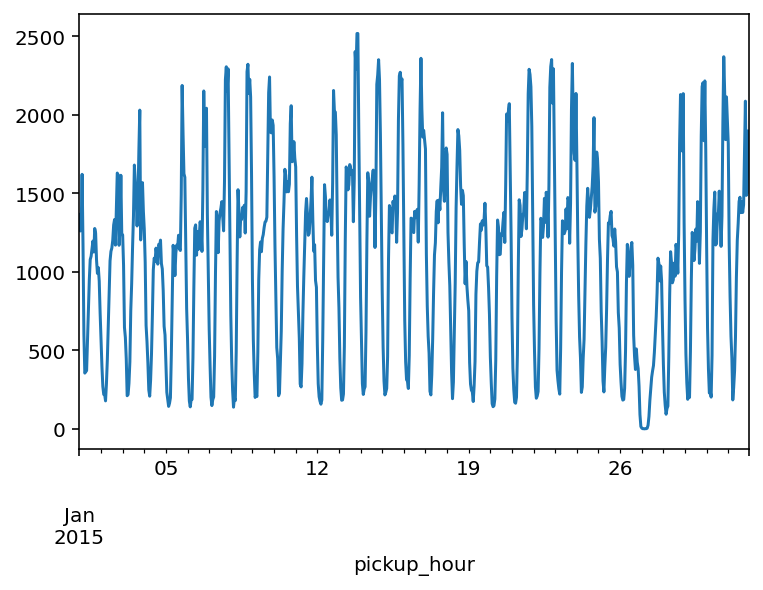

In [16]:
zip_df[zip_df['zip_code'] == '10019'].set_index('pickup_hour')['cnt'].plot();

### zip_code별 하루 단위 Trip - Box Plot

In [17]:
filter_zip_df = zip_df[zip_df['zip_code'].isin(filter_zip_code)]
filter_zip_df.head()

,zip_code,zip_code_geom,pickup_hour,cnt,date
0,11369,"POLYGON((-73.887731 40.766915, -73.887675 40.7...",2015-01-01,14,2015-01-01
2,10279,"POLYGON((-74.009254 40.713256, -74.009668 40.7...",2015-01-01,3,2015-01-01
4,11103,"MULTIPOLYGON(((-73.904137 40.76752, -73.904187...",2015-01-01,45,2015-01-01
5,11374,"POLYGON((-73.873907 40.728434, -73.873589 40.7...",2015-01-01,5,2015-01-01
8,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",2015-01-01,838,2015-01-01


In [18]:
len(filter_zip_code)

99

In [19]:
# 지역별 & 날짜별 trip 수
filter_zip_daily_df = filter_zip_df.groupby(['zip_code','date'])[['cnt']].sum().reset_index()
filter_zip_daily_df.head()

,zip_code,date,cnt
0,10001,2015-01-01,16770
1,10001,2015-01-02,17046
2,10001,2015-01-03,20478
3,10001,2015-01-04,16743
4,10001,2015-01-05,17441


In [20]:
# cufflinks => 드래그 가능
filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code').iplot(kind='box', x='zip_code')

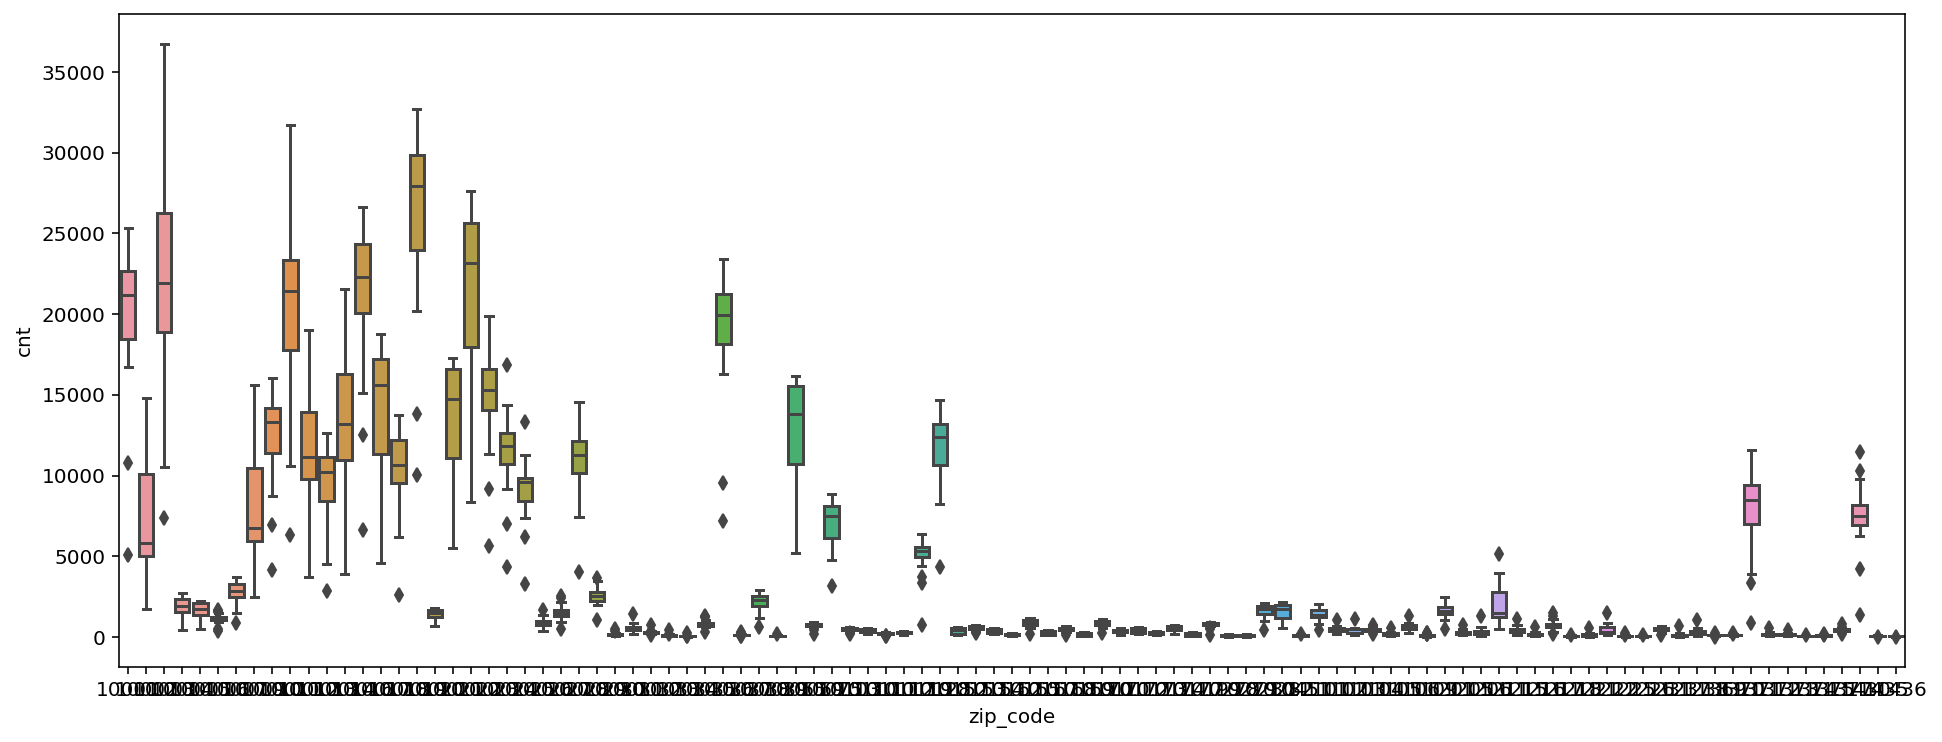

In [21]:
# seaborn
plt.figure(figsize=(16, 6));
sns.boxplot(x='zip_code', y='cnt', data=filter_zip_daily_df);

In [22]:
filter_zip_df[filter_zip_df['zip_code'] == '10019']

,zip_code,zip_code_geom,pickup_hour,cnt,date
32,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",2015-01-01 00:00:00,1367,2015-01-01
299,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",2015-01-01 01:00:00,1261,2015-01-01
351,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",2015-01-01 02:00:00,1296,2015-01-01
634,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",2015-01-01 03:00:00,1622,2015-01-01
680,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",2015-01-01 04:00:00,1175,2015-01-01
...,...,...,...,...,...
86483,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",2015-01-31 19:00:00,2088,2015-01-31
86597,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",2015-01-31 20:00:00,1488,2015-01-31
86753,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",2015-01-31 21:00:00,1504,2015-01-31
86802,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",2015-01-31 22:00:00,1899,2015-01-31


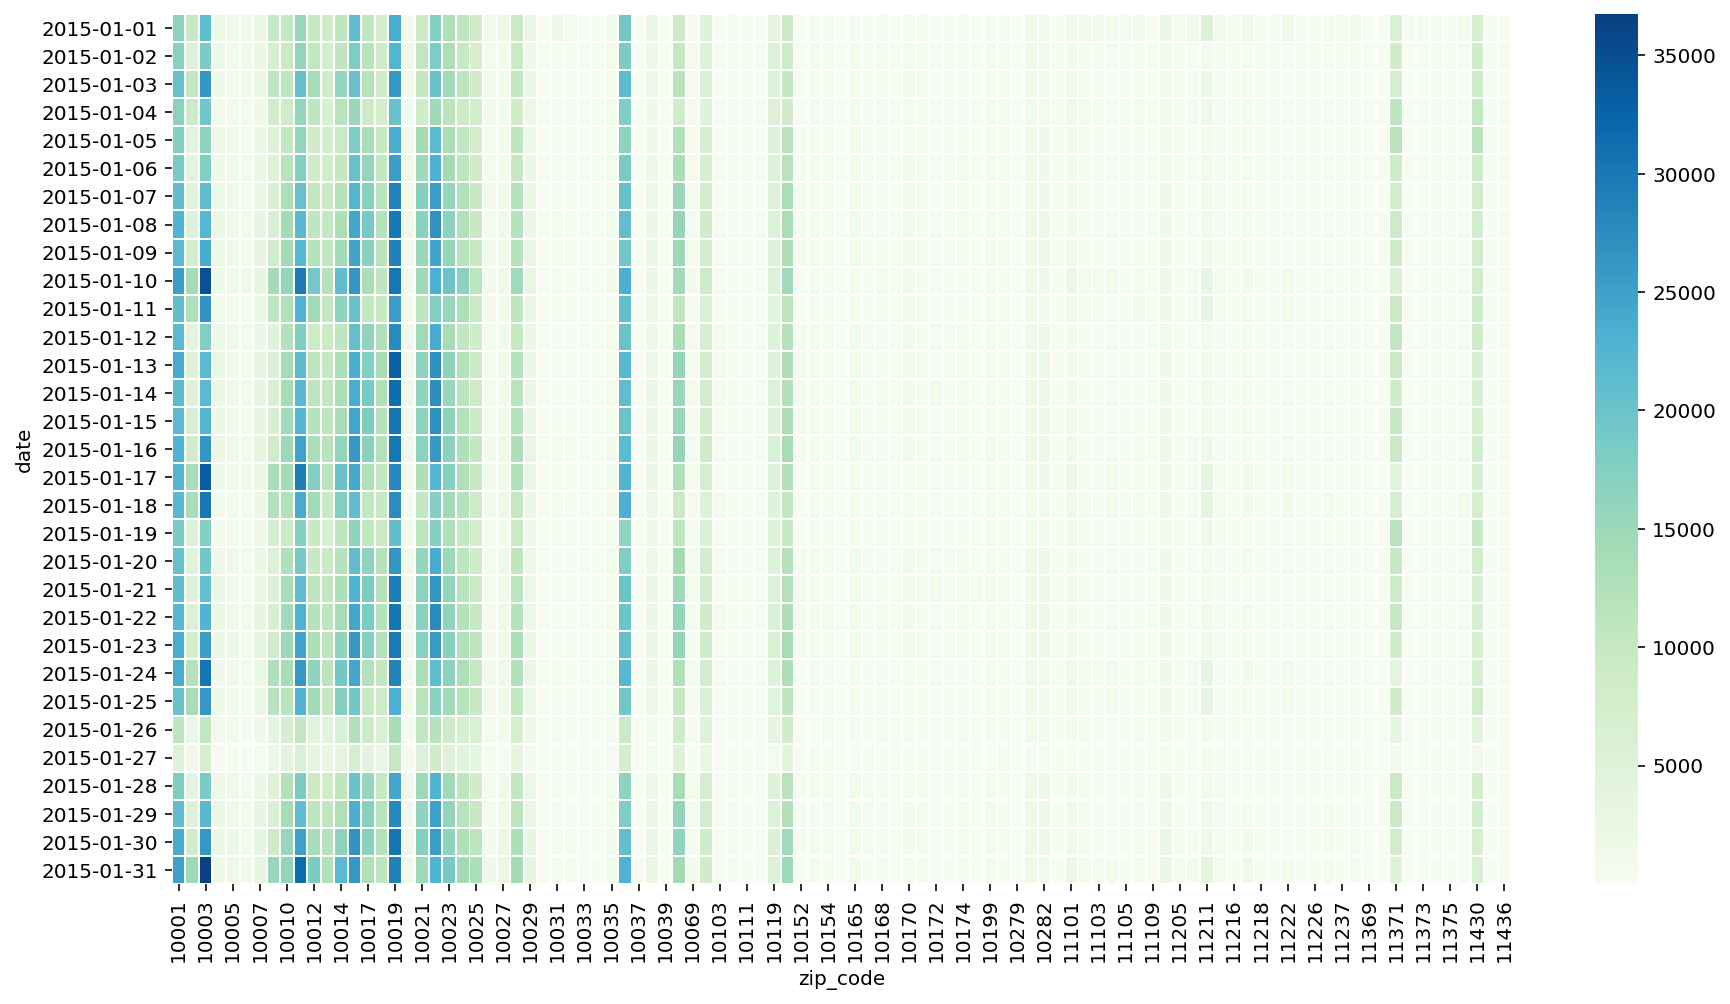

In [23]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code'),
           lw=.5, cmap='GnBu');

### 시간대별 zip_code의 추이

In [24]:
filter_zip_df['hour'] = filter_zip_df['pickup_hour'].dt.hour
filter_zip_df.head(3)

,zip_code,zip_code_geom,pickup_hour,cnt,date,hour
0,11369,"POLYGON((-73.887731 40.766915, -73.887675 40.7...",2015-01-01,14,2015-01-01,0
2,10279,"POLYGON((-74.009254 40.713256, -74.009668 40.7...",2015-01-01,3,2015-01-01,0
4,11103,"MULTIPOLYGON(((-73.904137 40.76752, -73.904187...",2015-01-01,45,2015-01-01,0


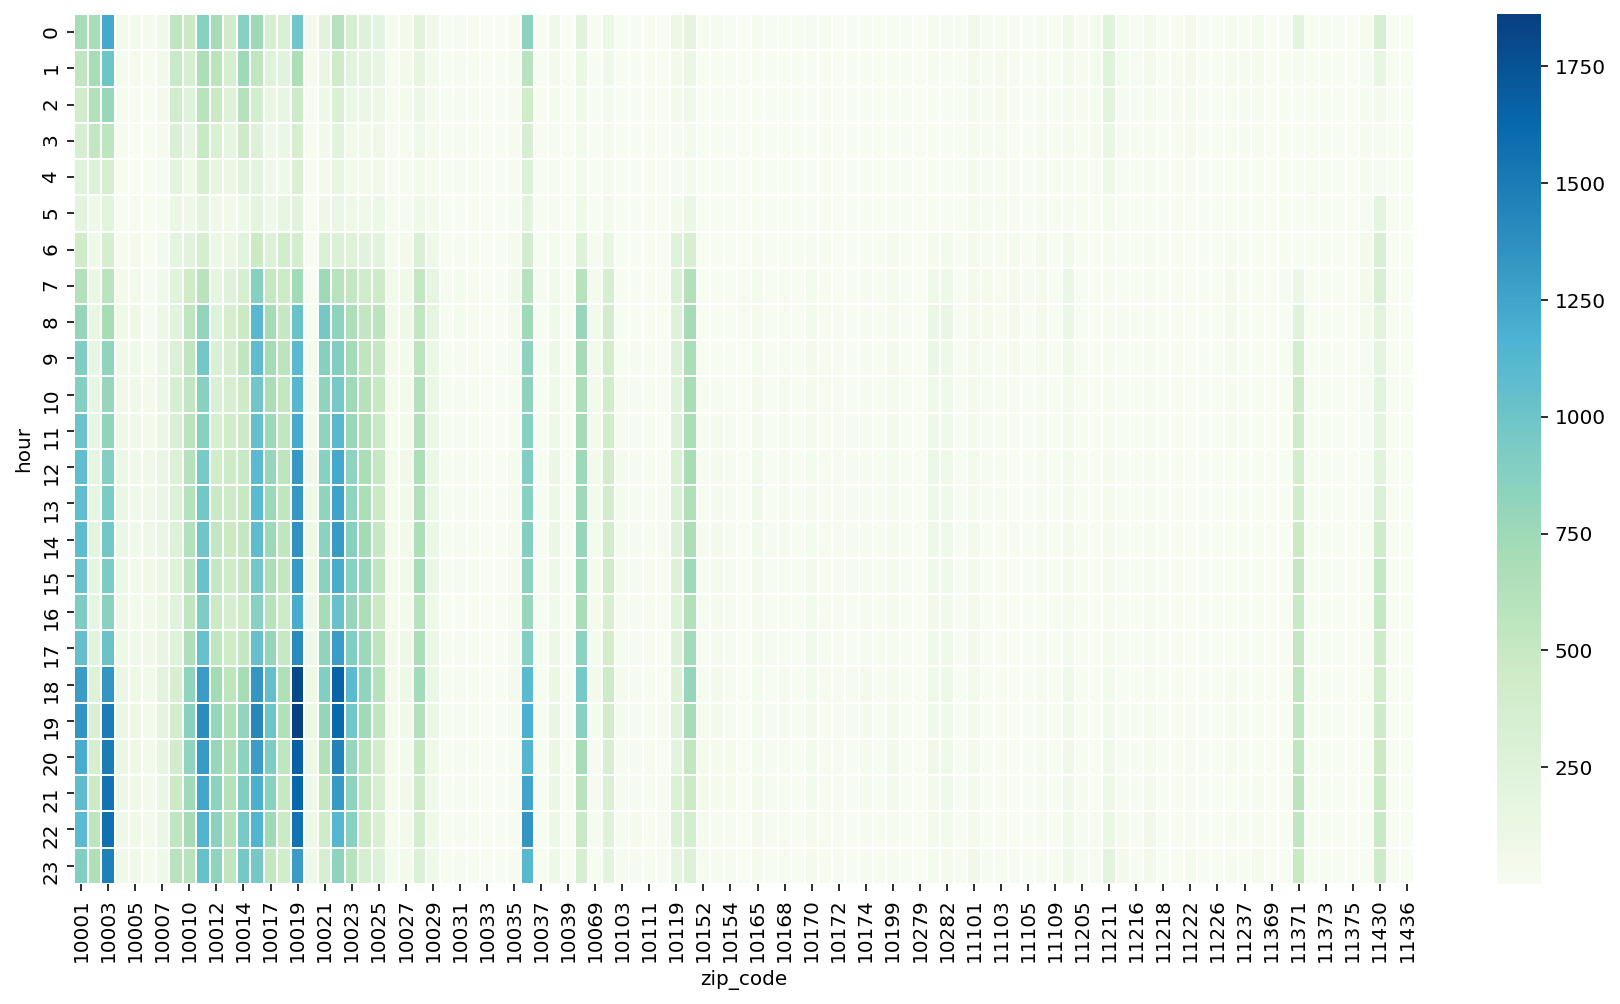

In [25]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_df.pivot_table('cnt', index='hour', columns='zip_code', aggfunc='mean'),
           lw=.5, cmap='GnBu');